In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

import math, os, random, cv2
import numpy as np
from PIL import Image

In [2]:
tf.config.list_physical_devices('GPU')

[]

In [3]:
PATH = "C:/Users/sonya/PythonProjects/image_classifier/output"

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
classes_num = len(train_dataset.class_names)

Found 558 files belonging to 13 classes.


In [4]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 382 files belonging to 13 classes.


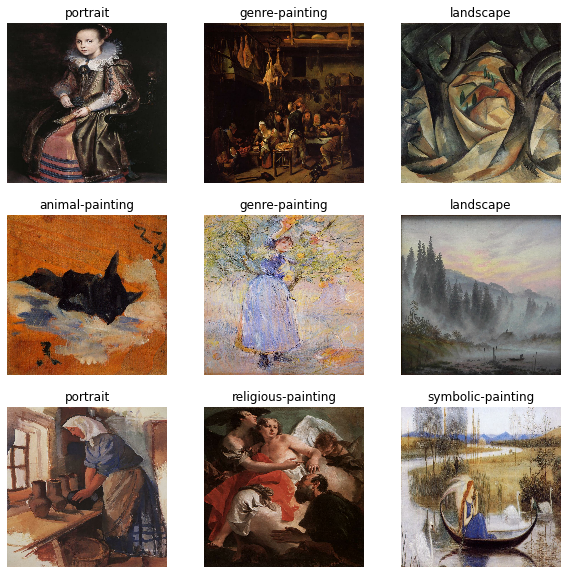

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [7]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 10
Number of test batches: 2


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

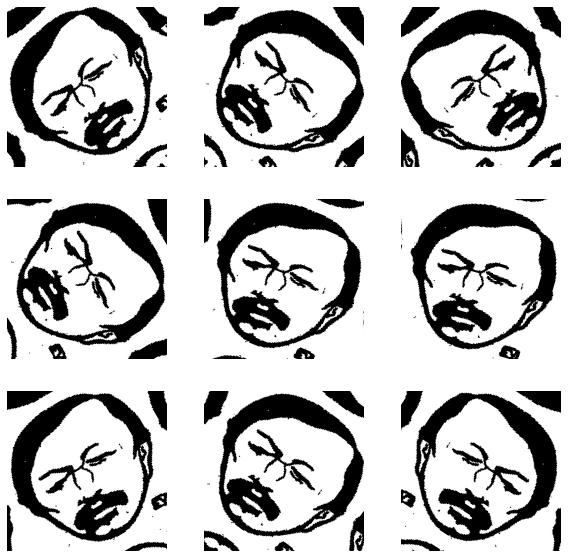

In [10]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [11]:
dir(tf.keras.applications)

['DenseNet121',
 'DenseNet169',
 'DenseNet201',
 'EfficientNetB0',
 'EfficientNetB1',
 'EfficientNetB2',
 'EfficientNetB3',
 'EfficientNetB4',
 'EfficientNetB5',
 'EfficientNetB6',
 'EfficientNetB7',
 'InceptionResNetV2',
 'InceptionV3',
 'MobileNet',
 'MobileNetV2',
 'MobileNetV3Large',
 'MobileNetV3Small',
 'NASNetLarge',
 'NASNetMobile',
 'ResNet101',
 'ResNet101V2',
 'ResNet152',
 'ResNet152V2',
 'ResNet50',
 'ResNet50V2',
 'VGG16',
 'VGG19',
 'Xception',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_sys',
 'densenet',
 'efficientnet',
 'imagenet_utils',
 'inception_resnet_v2',
 'inception_v3',
 'mobilenet',
 'mobilenet_v2',
 'mobilenet_v3',
 'nasnet',
 'resnet',
 'resnet50',
 'resnet_v2',
 'vgg16',
 'vgg19',
 'xception']

In [12]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [13]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [14]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [15]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [17]:
prediction_layer = tf.keras.layers.Dense(classes_num)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 13)


In [18]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [19]:
base_learning_rate = 0.0005
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [21]:
len(model.trainable_variables)

2

In [22]:
initial_epochs = len(train_dataset)

loss0, accuracy0 = model.evaluate(validation_dataset)

10/10 [==============================] - 5s 222ms/step - loss: 3.4042 - accuracy: 0.0723


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 3.40
initial accuracy: 0.07


In [24]:
def get_callbacks():
    return [tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)]

In [25]:
history = model.fit(train_dataset, epochs=initial_epochs, validation_data=validation_dataset, callbacks=get_callbacks())

Epoch 1/18
18/18 [==============================] - 12s 508ms/step - loss: 2.8501 - accuracy: 0.1595 - val_loss: 2.4613 - val_accuracy: 0.2264
Epoch 2/18
18/18 [==============================] - 10s 469ms/step - loss: 2.2987 - accuracy: 0.2814 - val_loss: 2.1835 - val_accuracy: 0.3208
Epoch 3/18
18/18 [==============================] - 9s 473ms/step - loss: 1.9649 - accuracy: 0.3495 - val_loss: 2.0876 - val_accuracy: 0.3648
Epoch 4/18
18/18 [==============================] - 10s 485ms/step - loss: 1.7759 - accuracy: 0.4570 - val_loss: 1.9432 - val_accuracy: 0.4025
Epoch 5/18
18/18 [==============================] - 10s 522ms/step - loss: 1.6204 - accuracy: 0.4624 - val_loss: 1.8898 - val_accuracy: 0.4057
Epoch 6/18
18/18 [==============================] - 10s 504ms/step - loss: 1.5809 - accuracy: 0.4713 - val_loss: 1.8386 - val_accuracy: 0.4214
Epoch 7/18
18/18 [==============================] - 10s 498ms/step - loss: 1.4158 - accuracy: 0.5215 - val_loss: 1.8069 - val_accuracy: 0.4371


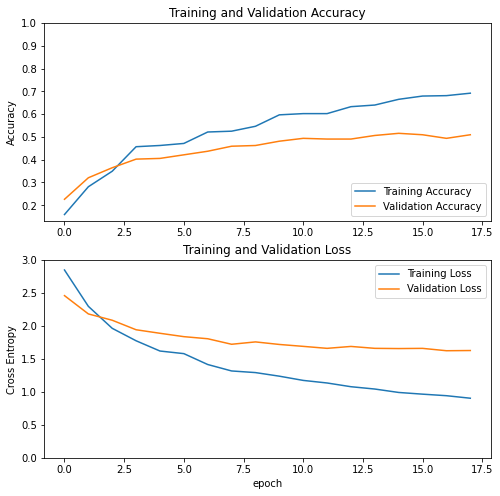

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,3.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [27]:
loss_test, accuracy_test = model.evaluate(test_dataset)
print('Test accuracy :', accuracy_test)

2/2 [==============================] - 2s 301ms/step - loss: 1.2384 - accuracy: 0.5781
Test accuracy : 0.578125


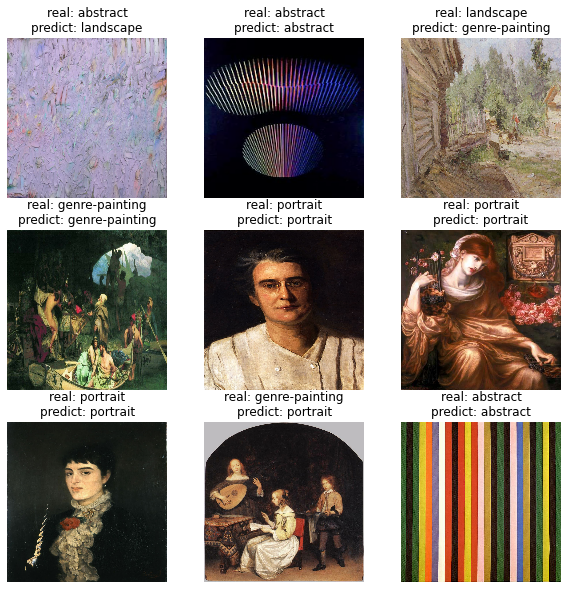

In [28]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)#.flatten()

def array_to_index(a):
    l = list(a)
    return l.index(max(l))

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    label_index = array_to_index(predictions[i])
    label = 'real: ' + class_names[label_batch[i]] + '\npredict: ' + class_names[label_index]
    plt.title(label)
    plt.axis("off")

In [29]:
base_model.trainable = True

print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [30]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [31]:
len(model.trainable_variables)

56

In [32]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)


Epoch 18/28
18/18 [==============================] - 15s 644ms/step - loss: 1.0915 - accuracy: 0.6272 - val_loss: 1.8200 - val_accuracy: 0.4717
Epoch 19/28
18/18 [==============================] - 12s 605ms/step - loss: 0.8991 - accuracy: 0.7025 - val_loss: 1.8038 - val_accuracy: 0.4937
Epoch 20/28
18/18 [==============================] - 12s 605ms/step - loss: 0.7947 - accuracy: 0.7151 - val_loss: 1.7376 - val_accuracy: 0.5189
Epoch 21/28
18/18 [==============================] - 12s 607ms/step - loss: 0.6220 - accuracy: 0.7814 - val_loss: 2.0592 - val_accuracy: 0.4686
Epoch 22/28
18/18 [==============================] - 12s 602ms/step - loss: 0.5789 - accuracy: 0.7903 - val_loss: 1.8040 - val_accuracy: 0.5314
Epoch 23/28
18/18 [==============================] - 12s 620ms/step - loss: 0.5275 - accuracy: 0.8136 - val_loss: 1.7380 - val_accuracy: 0.5000
Epoch 24/28
18/18 [==============================] - 12s 624ms/step - loss: 0.4240 - accuracy: 0.8674 - val_loss: 1.8950 - val_accuracy:

In [33]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

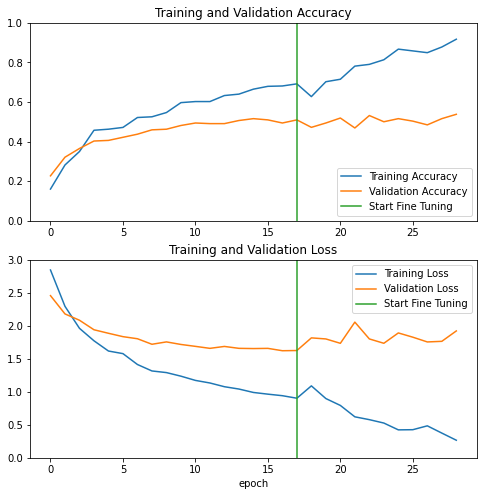

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 3.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [35]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

2/2 [==============================] - 2s 310ms/step - loss: 2.0163 - accuracy: 0.5625
Test accuracy : 0.5625


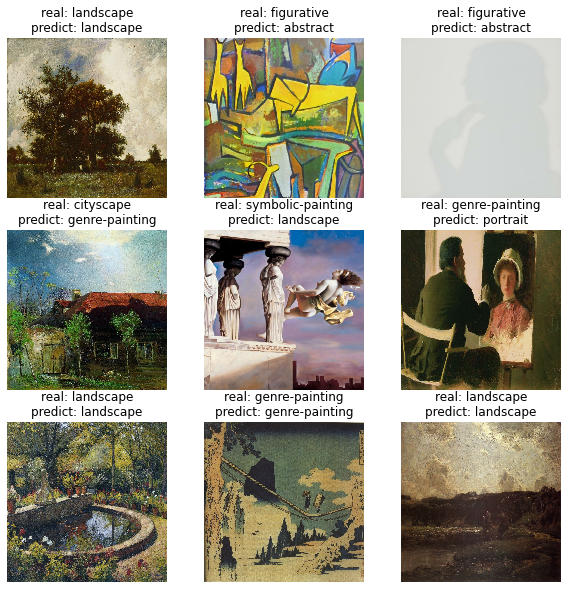

In [36]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)#.flatten()

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    label_index = array_to_index(predictions[i])
    label = 'real: ' + class_names[label_batch[i]] + '\npredict: ' + class_names[label_index]
    plt.title(label)
    plt.axis("off")

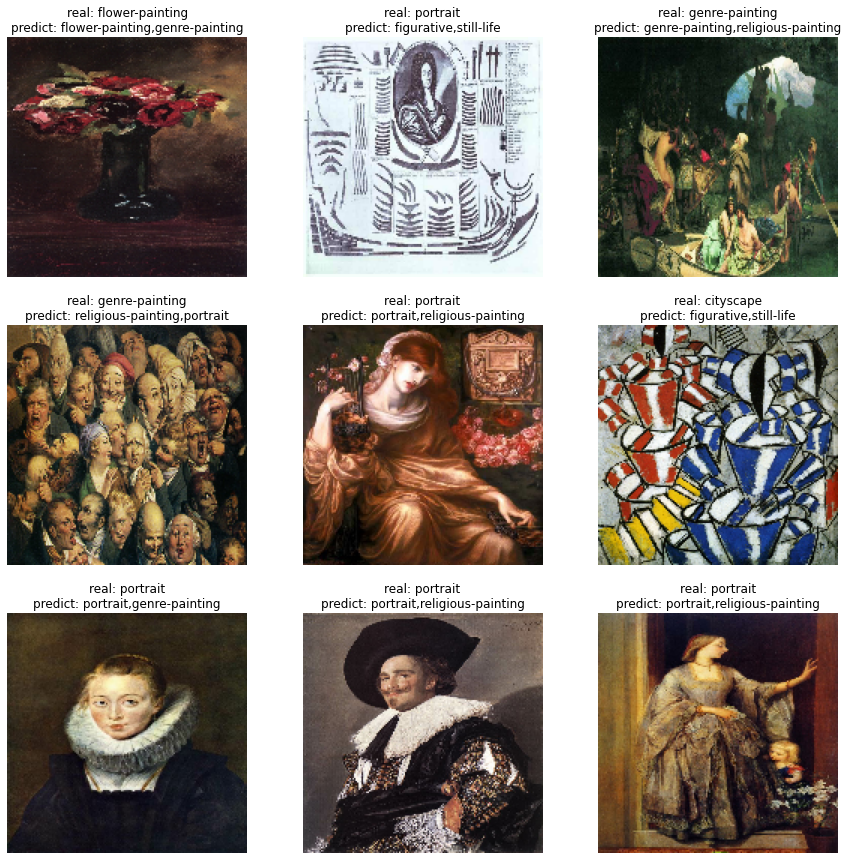

In [39]:
def array_to_index_sort(predictions):
    l = list(predictions)
    cp = list(predictions)
    l.sort(reverse=True)
    return cp.index(l[0]), cp.index(l[1])

image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)#.flatten()

plt.figure(figsize=(15, 15))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    label_index = array_to_index_sort(predictions[i])
    label = 'real: ' + class_names[label_batch[i]] + '\npredict: ' + class_names[label_index[0]] + ',' + class_names[label_index[1]]
    plt.title(label)
    plt.axis("off")